In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from time import time
from sympy import Symbol, diff, lambdify, sin, exp

In [15]:
#przedział funkcji
a = -4*math.pi
b = 3*math.pi
#liczba punktów na wykresach i przy obliczaniu błędów
points = 1000

In [16]:
def chebyshev_nodes(a, b, n):
    x = []
    for i in range(1, n + 1):
        x.append(0.5 * (a + b) + 0.5 * (b - a) * np.cos((2 * i - 1) / (2 * n) * np.pi))
    return x

In [17]:
def factorial(n): return n * factorial(n - 1) if n > 1 else 1

In [18]:
def newton_symbol(n, k):
    m = 1
    if (n < 0):
        n = k - n - 1
        m = (-1) ** k
    result = 1
    for i in range(k):
        result *= (n - i)
    result /= math.factorial(k)
    return m * result

In [19]:
def calc_derivate(func, n=1):
    x = Symbol('x')
    f = func(x)
    for i in range(1, n + 1):
        f = diff(f, x)

    return lambdify(x, f)


In [20]:
def data_plot(xs, ys, label=''):
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(xs, ys)
    if label: plt.legend(loc="best")


def func_plot(fn, a, b, n, label='', color='', figsize=(6, 4), subplot=None, title=''):
    if subplot is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        ax = subplot
    xs = np.linspace(a, b, num=n)
    ys = [fn(xi) for xi in xs]
    if color:
        ax.plot(xs, ys, label=label, color=color)
    else:
        ax.plot(xs, ys, label=label)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if label:
        ax.legend(loc="best")
    if title:
        ax.set_title(title)


In [21]:
def create_compare_errors_table(data):
    # data = {}
    # if lagrange_errors is not None:
    #     data["Interpolacja Lagrange'a"] = lagrange_errors
    # if newton_errors is not None:
    #     data["Interpolacja Newtona"] = newton_errors
    # if hermit_errors is not None:
    #     data["Interpolacja Hermite'a"] = hermit_errors
    df = pd.DataFrame(data, index=["Błąd bezwzględny", "Błąd średniokwadratowy"])
    return df


#### 1.5. Tabele

In [68]:
def max_absolute_error(f, W, xs):
    return max([abs(f(x) - W(x)) for x in xs])


In [23]:
def mse(f, W, xs):
    return sum([(f(x) - W(x)) ** 2 for x in xs]) / len(xs)

In [24]:
## Lagrange

In [25]:
def lagrange_interpolation(x, y):
    n = len(x) - 1
    m = []
    for i in range(n + 1):
        m_val = 1
        for j in range(n + 1):
            if j == i: continue
            m_val *= (x[i] - x[j])
        m.append(m_val)

    def f(x_arg):
        y_val = 0
        for k in range(n + 1):
            p = 1
            for j in range(n + 1):
                if j == k: continue
                p *= (x_arg - x[j])
            y_val += p * y[k] / m[k]
        return y_val

    return f

In [26]:
def lagrange_interpolation_func(f, a, b, n, chebyshev=False, ax=None):
    if chebyshev:
        x = chebyshev_nodes(a, b, n)
    else:
        x = np.linspace(a, b, n)
    y = [f(xi) for xi in x]
    if ax is not None:
        ax.plot(x, y, 'o', c="r")
    return lagrange_interpolation(x, y)

In [27]:
## Newton

In [28]:
def newton_interpolation(x, y):
    n = len(x)
    quoteint_difference_tab = [[y[j] if i == 0 else 0 for i in range(n)] for j in range(n)]
    for j in range(1, n):
        for i in range(j, n):
            quoteint_difference_tab[i][j] = (quoteint_difference_tab[i][j - 1] - quoteint_difference_tab[i - 1][
                j - 1]) / (x[i] - x[i - j])
    factor_tab = [quoteint_difference_tab[i][i] for i in range(n)]

    def f(x_arg):
        result = factor_tab[n - 1]
        for i in range(n - 2, -1, -1):
            result = result * (x_arg - x[i]) + factor_tab[i]
        return result

    return f

In [29]:
def newton_interpolation_eq(x, y):
    n = len(x)
    h = x[1] - x[0]
    diff_tab = [y[i] for i in range(n)]

    for j in range(1, n):
        for i in range(n - 1, j - 1, -1):
            diff_tab[i] = diff_tab[i] - diff_tab[i - 1]

    def f(x_arg):
        s = (x_arg - x[0]) / h
        result = 0
        for i in range(0, n):
            result += newton_symbol(s, i) * diff_tab[i]
        return result

    return f

In [30]:
def newton_interpolation_func(f, a, b, n, chebyshev=False, ax=None):
    if chebyshev:
        x = chebyshev_nodes(a, b, n)
        y = [f(xi) for xi in x]
        if ax is not None:
            ax.plot(x, y, 'o', c="r")
        return newton_interpolation(x, y)
    else:
        x = np.linspace(a, b, n)
        y = [f(xi) for xi in x]
        if ax is not None:
            ax.plot(x, y, 'o', c="r")
        return newton_interpolation_eq(x, y)

In [31]:
## Hermit

In [32]:
def hermite_interpolation(xs, ys):
    ms = [len(y_values) for y_values in ys]
    m = sum(ms)
    quoteint_difference_tab = [[None for _ in range(m)] for _ in range(m)]

    # lista argumentów z powtórzeniami
    xs_reps = []
    for i in range(len(xs)):
        xs_reps.extend([xs[i]] * ms[i])
    i = 0
    for y_values in ys:
        for j in range(len(y_values)):
            for k in range(j + 1):
                quoteint_difference_tab[i][k] = y_values[k] / factorial(k)
            i += 1
    for j in range(1, m):
        for i in range(j, m):
            if quoteint_difference_tab[i][j] is None:
                quoteint_difference_tab[i][j] = (quoteint_difference_tab[i][j - 1] - quoteint_difference_tab[i - 1][
                    j - 1]) / (xs_reps[i] - xs_reps[i - j])

    factor_tab = [quoteint_difference_tab[i][i] for i in range(m)]

    def f(x_arg):
        result = factor_tab[m - 1]
        for i in range(m - 2, -1, -1):
            result = result * (x_arg - xs_reps[i]) + factor_tab[i]
        return result


    return f

In [57]:
def hermite_interpolation_func(f, a, b, n,derivatives=True, derivate=None, chebyshev=False, ax=None):
    if chebyshev:
        x = chebyshev_nodes(a, b, n)
    else:
        x = np.linspace(a, b, n)
    if derivatives:
        if derivate is not None:
            y = [[f(x[i]), derivate(x[i])] for i in range(n)]
        else:
            derivate = calc_derivate(f_sympy, 1)
            y = [[f(x[i]), derivate(x[i])] for i in range(n)]

    else:
        y=[[f(x[i])] for i in range(n)]
    if ax is not None:
        ax.plot(x, [f(x_arg) for x_arg in x], 'o', c="r")
    return hermite_interpolation(x, y)

#### 1.7. Analiza

In [34]:
from IPython.display import Markdown
# def interpolation_analysis(f, a, b, n):
#     xs = np.linspace(a,b, points)
#     fig, axs = plt.subplots(1, 2, figsize=(12, 4))
#     hermit_linespace = hermite_interpolation_func(f,a,b,n, ax=axs[0])
#     hermit_chebyshev = hermite_interpolation_func(f,a,b,n, chebyshev=True, ax=axs[1])
#
#
#     hermit_linespace_errors = [max_absolute_error(f, hermit_linespace ,xs), mse(f,hermit_linespace ,xs)]
#     hermit_chebyshev_errors = [max_absolute_error(f,hermit_chebyshev, xs), mse(f,hermit_chebyshev, xs)]
#
#     func_plot(f, a, b, points , label='f', subplot=axs[0], title="Rozkład równomierny")
#     func_plot(hermit_linespace, a, b, points , label='Hermit', subplot=axs[0])
#     func_plot(f, a, b, points, label='f', subplot=axs[1], title="Węzły chebysheva")
#     func_plot(hermit_chebyshev, a, b, points , label='Hermit', subplot=axs[1])
#     plt.show()
#     display(Markdown("""#### Wartości błędów dla węzłów rozłożonych równomiernie"""))
#     display(create_compare_errors_table(hermit_linespace_errors))
#     display(Markdown("""#### Wartości błędów dla węzłów Czebyszewa"""))
#     display(create_compare_errors_table(hermit_chebyshev_errors))

def display_interpolation(f, a,b,n, interpolations, labels,colors=[],chebyshev=False, title=""):
    xs = np.linspace(a,b, points)

    fig, ax = plt.subplots(figsize=(6, 4))
    polynomials = []
    for interpolation in interpolations:
        polynomials.append(interpolation(f,a,b,n,chebyshev=chebyshev, ax=ax))
    poly_n = len(polynomials)
    # W = interpolation(f,a,b,n,chebyshev=chebyshev, ax=ax)
    # poly_errors = []
    poly_errors = {}
    func_plot(f, a, b, 1000, label="f(x)", subplot=ax)
    while len(colors) < poly_n:
        colors.append('')
    for i in range(poly_n):
        func_plot(polynomials[i], a, b, 1000, label=labels[i], subplot=ax, color=colors[i], title=title)
        # poly_errors.append([max_absolute_error(f, polynomials[i] ,xs), mse(f,polynomials[i] ,xs)])
        poly_errors[labels[i]] = [max_absolute_error(f, polynomials[i] ,xs), mse(f,polynomials[i] ,xs)]
    # if colors is not None:
    #     for i in range(len(polynomials)):
    #         func_plot(polynomials[i], a, b, 1000, label=labels[i], subplot=ax, color=colors[i], title=title)
    # else:
    #     func_plot(W, a, b, 1000, label=label, subplot=ax, title=title)

    plt.show()
    display(create_compare_errors_table(poly_errors))
    # data = {label:W_errors}
    # df = pd.DataFrame(data, index=["Błąd bezwzględny", "Błąd średniokwadratowy"])
    # display(df)

#### 1.8. Pomiar czasu

In [35]:
def display_time(sec):
    hours = int(sec // 3600)
    minutes = int((sec % 3600) // 60)
    seconds = int(sec % 60)
    print(f"Czas trwania algorytmu: {hours} godzin {minutes} minut {seconds} sekund")

In [54]:
f_sympy = lambda x, k=4, m=1: exp(-k * sin(m * x)) + k * sin(m * x) - 1

In [53]:
f = lambda x, k=4, m=1: math.exp(-k * math.sin(m * x)) + k * math.sin(m * x) - 1

#### 2.1. Wykres funkcji $ f(x) $

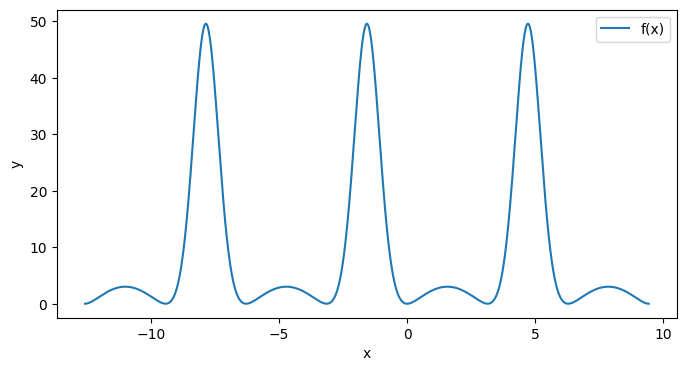

In [37]:
func_plot(f, a, b, 1000, label="f(x)", figsize=(8,4))

#### 2.2. Analiza interpolacji dla różnej ilości węzłów $n$
- $ n = 5 $

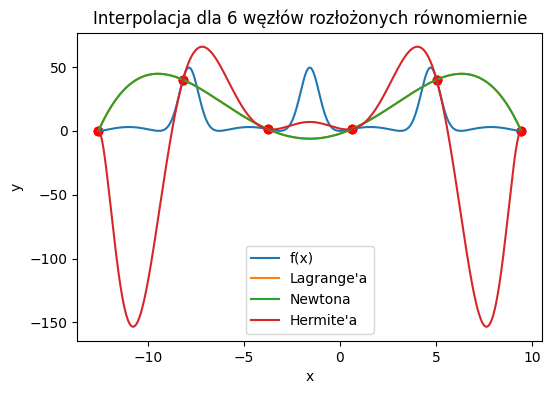

,Lagrange'a,Newtona,Hermite'a
Błąd bezwzględny,55.719300,55.719300,156.341800
Błąd średniokwadratowy,640.201297,640.201297,4260.711126


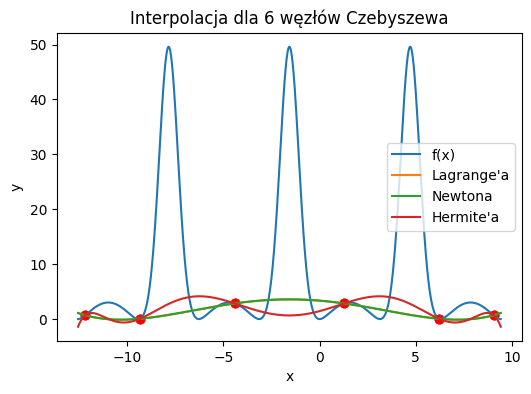

,Lagrange'a,Newtona,Hermite'a
Błąd bezwzględny,48.836700,48.836700,48.926700
Błąd średniokwadratowy,262.062188,262.062188,257.537559


In [58]:
n= 6
display_interpolation(f,a,b,n, [lagrange_interpolation_func, newton_interpolation_func, hermite_interpolation_func],
                      labels=[ "Lagrange'a", "Newtona", "Hermite'a" ],
                      title="Interpolacja dla 6 węzłów rozłożonych równomiernie"
                                                                                        )
display_interpolation(f,a,b,n, [lagrange_interpolation_func, newton_interpolation_func, hermite_interpolation_func],
                      labels=[ "Lagrange'a", "Newtona", "Hermite'a" ],
                      title="Interpolacja dla 6 węzłów Czebyszewa", chebyshev=True
                                                                                        )

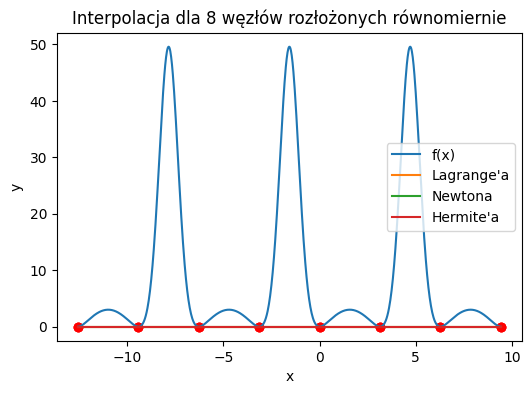

,Lagrange'a,Newtona,Hermite'a
Błąd bezwzględny,49.5979,49.5979,49.5979
Błąd średniokwadratowy,288.1865,288.1865,288.1865


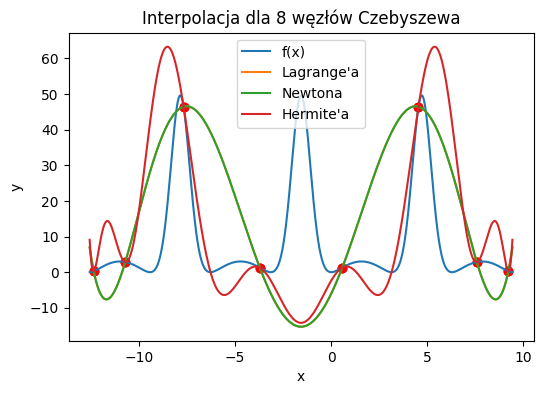

,Lagrange'a,Newtona,Hermite'a
Błąd bezwzględny,64.8801,64.8801,63.7891
Błąd średniokwadratowy,564.9673,564.9673,503.3445


In [61]:
n= 8
display_interpolation(f,a,b,n, [lagrange_interpolation_func, newton_interpolation_func, hermite_interpolation_func],
                      labels=[ "Lagrange'a", "Newtona", "Hermite'a" ],
                      title="Interpolacja dla 8 węzłów rozłożonych równomiernie"
                                                                                        )
display_interpolation(f,a,b,n, [lagrange_interpolation_func, newton_interpolation_func, hermite_interpolation_func],
                      labels=[ "Lagrange'a", "Newtona", "Hermite'a" ],
                      title="Interpolacja dla 8 węzłów Czebyszewa", chebyshev=True
                                                                                        )

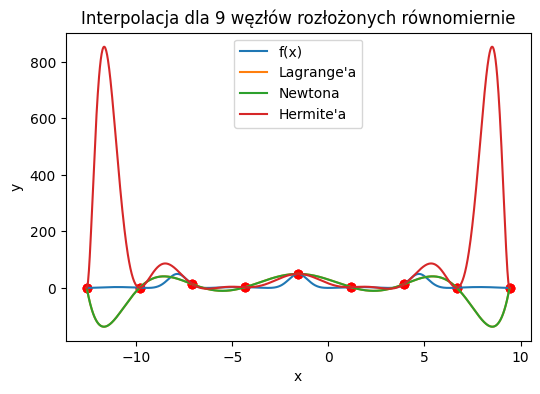

,Lagrange'a,Newtona,Hermite'a
Błąd bezwzględny,139.6334,139.6334,851.9588
Błąd średniokwadratowy,2525.6166,2525.6166,63167.9070


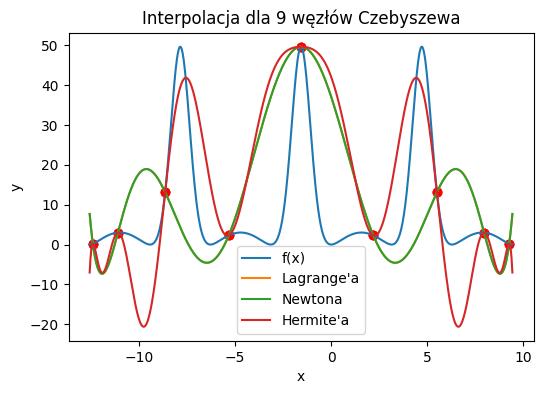

,Lagrange'a,Newtona,Hermite'a
Błąd bezwzględny,45.5626,45.5626,44.2930
Błąd średniokwadratowy,413.4189,413.4189,357.1848


In [63]:
n= 9
display_interpolation(f,a,b,n, [lagrange_interpolation_func, newton_interpolation_func, hermite_interpolation_func],
                      labels=[ "Lagrange'a", "Newtona", "Hermite'a" ],
                      title=f"Interpolacja dla {n} węzłów rozłożonych równomiernie"
                                                                                        )
display_interpolation(f,a,b,n, [lagrange_interpolation_func, newton_interpolation_func, hermite_interpolation_func],
                      labels=[ "Lagrange'a", "Newtona", "Hermite'a" ],
                      title=f"Interpolacja dla {n} węzłów Czebyszewa", chebyshev=True
                                                                                        )

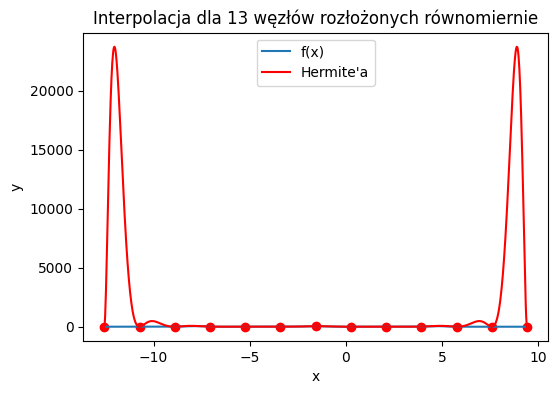

,Hermite'a
Błąd bezwzględny,23729.3756
Błąd średniokwadratowy,29618056.1705


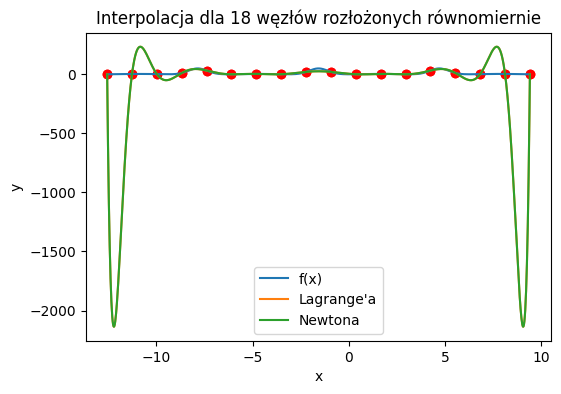

,Lagrange'a,Newtona
Błąd bezwzględny,2137.8333,2137.8333
Błąd średniokwadratowy,226932.2819,226932.2819


In [74]:
n= 13
display_interpolation(f,a,b,n, [ hermite_interpolation_func],
                      labels=["Hermite'a" ], colors=["red"],
                      title=f"Interpolacja dla {n} węzłów rozłożonych równomiernie"
                                                                                        )
display_interpolation(f,a,b,18, [lagrange_interpolation_func, newton_interpolation_func],
                      labels=[ "Lagrange'a", "Newtona", "Hermite'a" ],
                      title=f"Interpolacja dla 18 węzłów rozłożonych równomiernie"
                                                                                        )

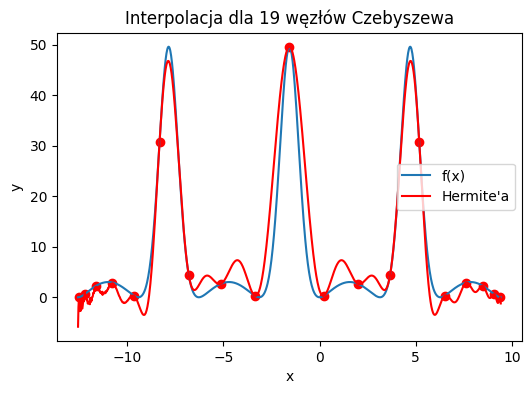

,Hermite'a
Błąd bezwzględny,14.3057
Błąd średniokwadratowy,16.3684


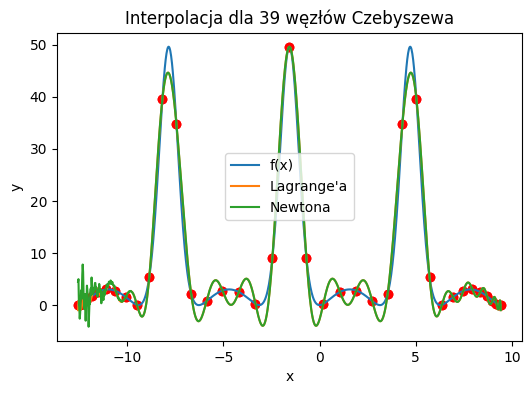

,Lagrange'a,Newtona
Błąd bezwzględny,5.1149,7.4491
Błąd średniokwadratowy,5.1157,5.4087


In [86]:
n= 19
display_interpolation(f,a,b,n, [hermite_interpolation_func],
                      labels=["Hermite'a" ], colors=["red"],
                      title=f"Interpolacja dla {n} węzłów Czebyszewa", chebyshev=True,
                                                                                        )
display_interpolation(f,a,b,39, [lagrange_interpolation_func, newton_interpolation_func],
                      labels=[ "Lagrange'a", "Newtona" ],
                      title=f"Interpolacja dla 39 węzłów Czebyszewa", chebyshev=True
                                                                                        )

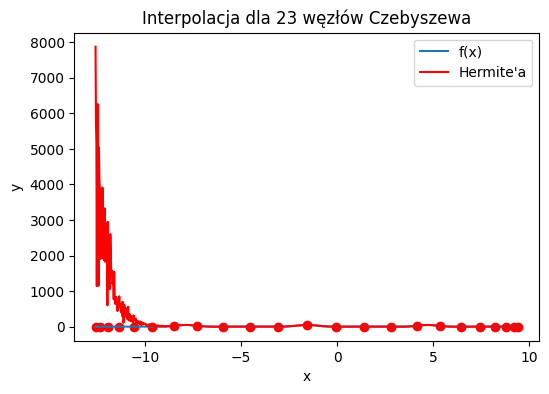

,Hermite'a
Błąd bezwzględny,7874.9967
Błąd średniokwadratowy,459972.7951


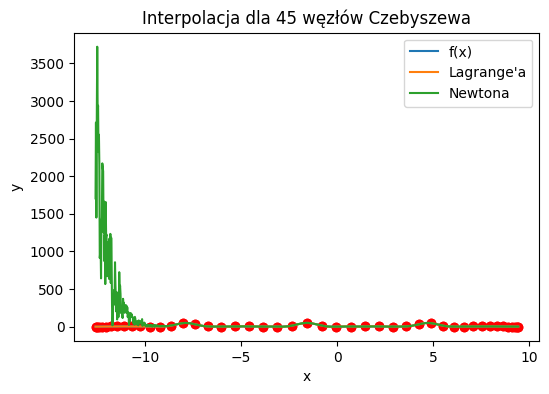

,Lagrange'a,Newtona
Błąd bezwzględny,2.5024,3721.9058
Błąd średniokwadratowy,0.7316,115569.8000


In [89]:
n= 23
display_interpolation(f,a,b,n, [hermite_interpolation_func],
                      labels=["Hermite'a" ], colors=["red"],
                      title=f"Interpolacja dla {n} węzłów Czebyszewa", chebyshev=True,
                                                                                        )
display_interpolation(f,a,b,45, [lagrange_interpolation_func, newton_interpolation_func],
                      labels=[ "Lagrange'a", "Newtona" ],
                      title=f"Interpolacja dla 45 węzłów Czebyszewa", chebyshev=True
                                                                                        )

##### 2.3.1. Algorytm realizujący szukanie najlepszego wielomianu

In [60]:
derivate = calc_derivate(f_sympy, 1)
def find_best_polynomial(f, n_max, interpolation, chebyshev=False, derivate=None):
    start_time = time()
    xs = np.linspace(a,b, points)
    best_n = 2
    min_mse = float('inf')
    for n in range(2, n_max+1):
        if derivate is not None:
            W = interpolation(f, a, b, n, chebyshev=chebyshev, derivate=derivate)
        else:
            W = interpolation(f, a, b, n, chebyshev=chebyshev)
        W_mse = mse(f, W, xs)
        if W_mse < min_mse:
            min_mse = W_mse
            best_n = n
    end_time = time()
    display_time(end_time-start_time)
    return best_n

In [64]:
find_best_polynomial(f, 15, lagrange_interpolation_func)

Czas trwania algorytmu: 0 godzin 0 minut 0 sekund


4

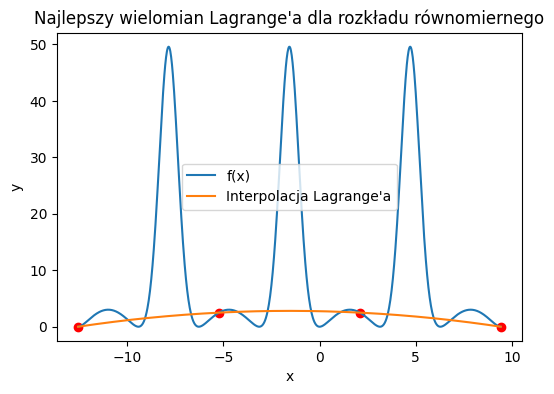

,Interpolacja Lagrange'a
Błąd bezwzględny,47.707700
Błąd średniokwadratowy,253.709635


In [65]:
n = 4
display_interpolation(f,a,b,n, [lagrange_interpolation_func],
                      labels=["Interpolacja Lagrange'a" ],
                      title=f"Najlepszy wielomian Lagrange'a dla rozkładu równomiernego", chebyshev=False,
                                                                                        )

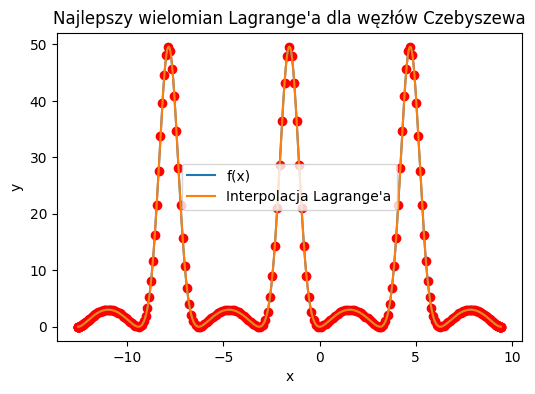

,Interpolacja Lagrange'a
Błąd bezwzględny,1.350031e-13
Błąd średniokwadratowy,4.025563e-28


In [69]:

n = 273
display_interpolation(f, a, b, n, [lagrange_interpolation_func],
                      labels=["Interpolacja Lagrange'a"],
                      title=f"Najlepszy wielomian Lagrange'a dla węzłów Czebyszewa", chebyshev=True,
                      )

In [70]:
find_best_polynomial(f, 15, newton_interpolation_func)

Czas trwania algorytmu: 0 godzin 0 minut 0 sekund


4

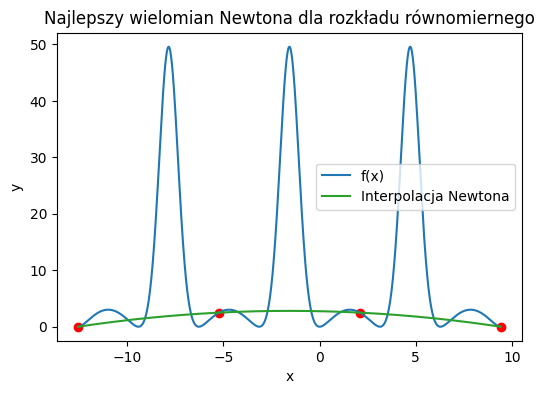

,Interpolacja Newtona
Błąd bezwzględny,47.7077
Błąd średniokwadratowy,253.7096


In [35]:
n = 4
display_interpolation(f,a,b,n, [newton_interpolation_func],
                      labels=["Interpolacja Newtona" ], colors=["#2ca02c"],
                      title=f"Najlepszy wielomian Newtona dla rozkładu równomiernego", chebyshev=False,
                                                                                        )

In [91]:
find_best_polynomial(f, 45, newton_interpolation_func, chebyshev=True)

Czas trwania algorytmu: 0 godzin 0 minut 0 sekund


40

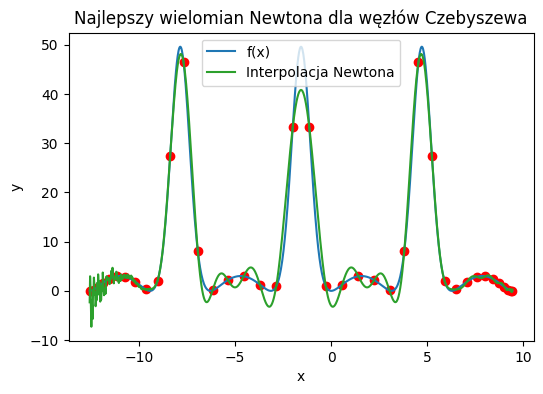

,Interpolacja Newtona
Błąd bezwzględny,8.771602
Błąd średniokwadratowy,4.900118


In [75]:
n = 40
display_interpolation(f,a,b,n, [newton_interpolation_func],
                      labels=["Interpolacja Newtona" ], colors=["#2ca02c"],
                      title=f"Najlepszy wielomian Newtona dla węzłów Czebyszewa", chebyshev=True,
                                                                                        )

In [76]:
find_best_polynomial(f, 15, hermite_interpolation_func, chebyshev=False, derivate=derivate)

Czas trwania algorytmu: 0 godzin 0 minut 0 sekund


4

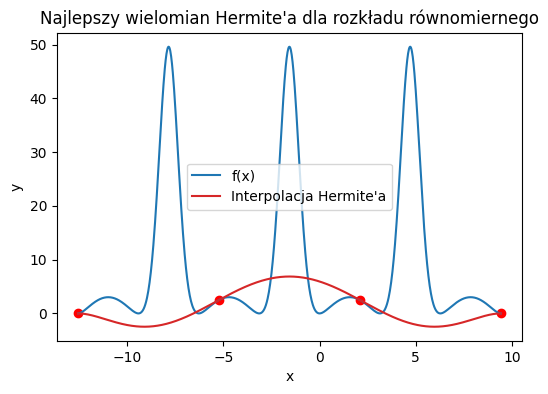

,Interpolacja Hermite'a
Błąd bezwzględny,51.424135
Błąd średniokwadratowy,279.996767


In [90]:
n = 4
display_interpolation(f,a,b,n, [hermite_interpolation_func],
                      labels=["Interpolacja Hermite'a" ], colors=["#d62728"],
                      title=f"Najlepszy wielomian Hermite'a dla rozkładu równomiernego", chebyshev=False,
                                                                                        )

In [79]:
find_best_polynomial(f, 45, hermite_interpolation_func, chebyshev=True, derivate=derivate)

Czas trwania algorytmu: 0 godzin 0 minut 0 sekund


20

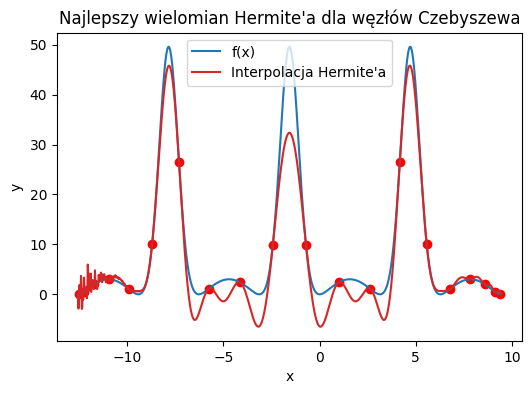

,Interpolacja Hermite'a
Błąd bezwzględny,17.232261
Błąd średniokwadratowy,14.323939


In [85]:
n = 20
display_interpolation(f,a,b,n, [hermite_interpolation_func],
                      labels=["Interpolacja Hermite'a" ], colors=["#d62728"],
                      title=f"Najlepszy wielomian Hermite'a dla węzłów Czebyszewa", chebyshev=True,
                                                                                        )